# Non-negative integration of gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates how to apply a non-negative version (experimental) of `MuVI` on multiple modalities, e.g. RNA-seq and ATAC-seq, in order to infer a joint latent space that is informed a priori by existing domain knowledge in terms of gene set annotations.

This tutorial extends the excellent [muon-tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.html) on applying [MOFA](https://biofam.github.io/MOFA2/) to single-cell gene expression and chromatin accessibility for inferring a joint latent space across multiple modalities.
Please refer to [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.html) for processing the RNA modality, and [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) for processing the ATAC modality.

In [1]:
import pandas as pd
import mudata as mu

In [2]:
import muvi

In [3]:
%matplotlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f5c63cfeb30>


In [4]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [5]:
device = "cpu"
try:
    device = f"cuda:{muvi.get_free_gpu_idx()}"
except Exception as e:
    print(e)

Load the MuData object from the `.h5mu` file:

In [6]:
mdata = mu.read("../../../data/muvi/pbmc10k_subset_embo.h5mu")
mdata

/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 9534 × 9026
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    atac:	9534 x 6000
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors'
    rna:	9534 x 3026
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors'

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [7]:
gene_set_collection = muvi.fs.from_gmt(
    "../msigdb/c8.all.v7.5.1.symbols.gmt", name="celltype"
)
gene_set_collection

<FeatureSets 'celltype' with 700 feature sets>

To reduce the number of feature sets to more specific ones for our dataset, we filter for blood and bone related cell types only.

In [8]:
gene_set_collection = gene_set_collection.find("BONE")
gene_set_collection

<FeatureSets 'celltype:BONE' with 29 feature sets>

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [9]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15
)
gene_set_collection

<FeatureSets 'celltype:BONE' with 14 feature sets>

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In our case, we may only inform the RNA view, and expect the ATAC view to be informed implicitly during the inference of shared latent factors.

Finally, we convert the prior information into a numerical representation such as a binary matrix.

In [10]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    mdata["rna"].var_names.tolist()
).T

Create a `MuVI` model directly from the `MuData` object by providing the necessary arguments such as the `varm` key for the numerically encoded prior information of the gene set annotations.

In [11]:
# set `nmf=True` for both views to enforce the non-negative constraint
model = muvi.tl.from_mdata(
    mdata,
    prior_mask_key="gene_set_mask",
    view_names=["rna", "atac"],
    prior_confidence="med",
    n_factors=1,
    nmf=True,
    device=device,
)
model

2024-06-21 15:40:54,834 - muvi.tools.utils - WARNING - Invalid `prior_mask_key`, `gene_set_mask` not found in `varm`.
2024-06-21 15:40:55,441 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 15:40:55,442 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2024-06-21 15:40:55,443 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 15:40:55,445 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 15:40:55,446 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 15:40:55,449 - muvi.core.models - INFO - pd.DataFrame detected.
2024-06-21 15:40:55,453 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2024-06-21 15:40:55,454 - muvi.core.models - INFO - Mask for view `atac` not found, assuming `atac` to be uninformed.
2024-06-21 15:40:55,457 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal', 'atac': 'normal'}`.
2024-06-21 15:40:55,457 - muvi.core.models - INFO - NMF set to `{'rna

|==============================================|
|              MuVI version 0.1.3              |
|==============================================|
| Parameter        | Value                     |
|------------------|---------------------------|
| n_views          | 2                         |
| n_samples        | 9534                      |
| n_features       | rna: 3026, atac: 6000     |
| n_factors        | 15                        |
| prior_confidence | 0.995                     |
| n_covariates     | 0                         |
| likelihoods      | rna: normal, atac: normal |
| nmf              | rna: True, atac: True     |
| reg_hs           | True                      |
| pos_transform    | relu                      |
| device           | cuda:2                    |
|==============================================|

Train the model using stochastic variational inference (SVI) in order to utilize smaller batches of the whole dataset to avoid loading the whole dataset onto the GPU. The training takes around 7 minutes on a single Quadro RTX 5000 NVIDIA GPU.

In [12]:
model.fit(seed=0)

2024-06-21 15:40:56,158 - muvi.core.models - INFO - Preparing model and guide...
2024-06-21 15:40:56,280 - muvi.core.models - INFO - Preparing optimizer...
2024-06-21 15:40:56,281 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2024-06-21 15:40:56,281 - muvi.core.models - INFO - Preparing SVI...
2024-06-21 15:40:56,282 - muvi.core.models - INFO - Preparing training data...
2024-06-21 15:40:56,383 - muvi.core.models - INFO - Using complete dataset.
2024-06-21 15:40:56,489 - muvi.core.models - INFO - Setting training seed to `0`.
2024-06-21 15:40:56,492 - muvi.core.models - INFO - Cleaning parameter store.
2024-06-21 15:40:56,493 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2024-06-21 15:40:58,018 - root - INFO - Guessed max_plate_nesting = 2


 20%|█▉        | 1950/10000 [03:52<16:00,  8.38it/s, ELBO=1.09e+4]

Relative improvement of 1.792e-07 < 1e-05 for 10 step(s) in a row, stopping early.
2024-06-21 15:44:49,177 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [13]:
# first, lets prettify the names of the factors
# assume format: COLLECTION_SOME_LONG_GENE_SET_NAME|COLLECTION_SOME_OTHER_LONG_GENE_SET_NAME
# return format: Some Long...Name (C)|Some Other...Name (C)
def prettify(name, max_len=50):
    def prettify_single(name, max_len):
        if "dense" in name:
            return name
        parts = name.split("_")
        parts[0] = f"({parts[0][0]})"
        parts = parts[1:] + parts[:1]
        new_name = " ".join(parts)
        if len(new_name) > max_len:
            half_len = (max_len) // 2
            new_name = new_name[: half_len - 2] + "..." + new_name[-half_len + 1 :]
        return new_name.title()

    parts = name.split("|")
    max_len = max_len // len(parts)
    return "|".join([prettify_single(part, max_len) for part in parts])


model.factor_names = model.factor_names.map(prettify)

2024-06-21 15:44:49,467 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2024-06-21 15:44:49,602 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniconda3/envs/muvi_main/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


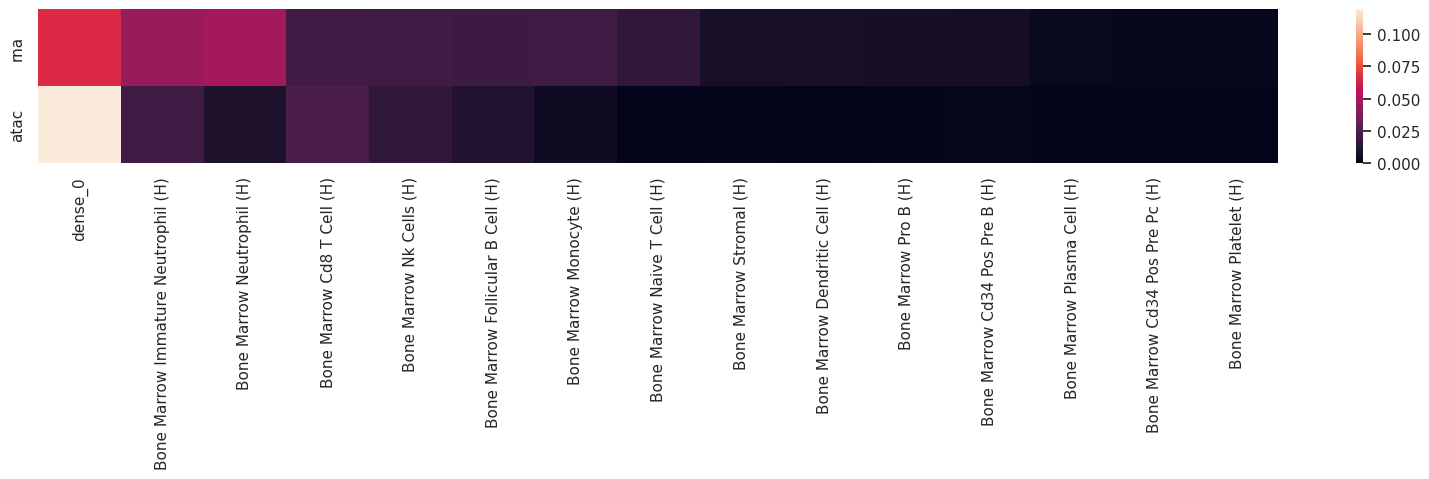

<Axes: >

In [14]:
# to speed up the process, use a random subsample to approximate the variance explained
muvi.tl.variance_explained(model, subsample=1000)
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation. Since we only inform the RNA view, we may not apply this function on the uninformed views such as the ATAC view in our case.

In [15]:
_ = muvi.tl.test(model)

2024-06-21 15:44:51,296 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]

2024-06-21 15:44:53,267 - muvi.tools.utils - WARNING - No feature sets provided for `rna`, extracting feature sets from the prior mask.



100%|██████████| 14/14 [00:01<00:00,  7.84it/s]


Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

For the uninformed views, i.e. ATAC, we omit any information regarding the statistical testing, and only sort the factors by their corresponding variance explained.

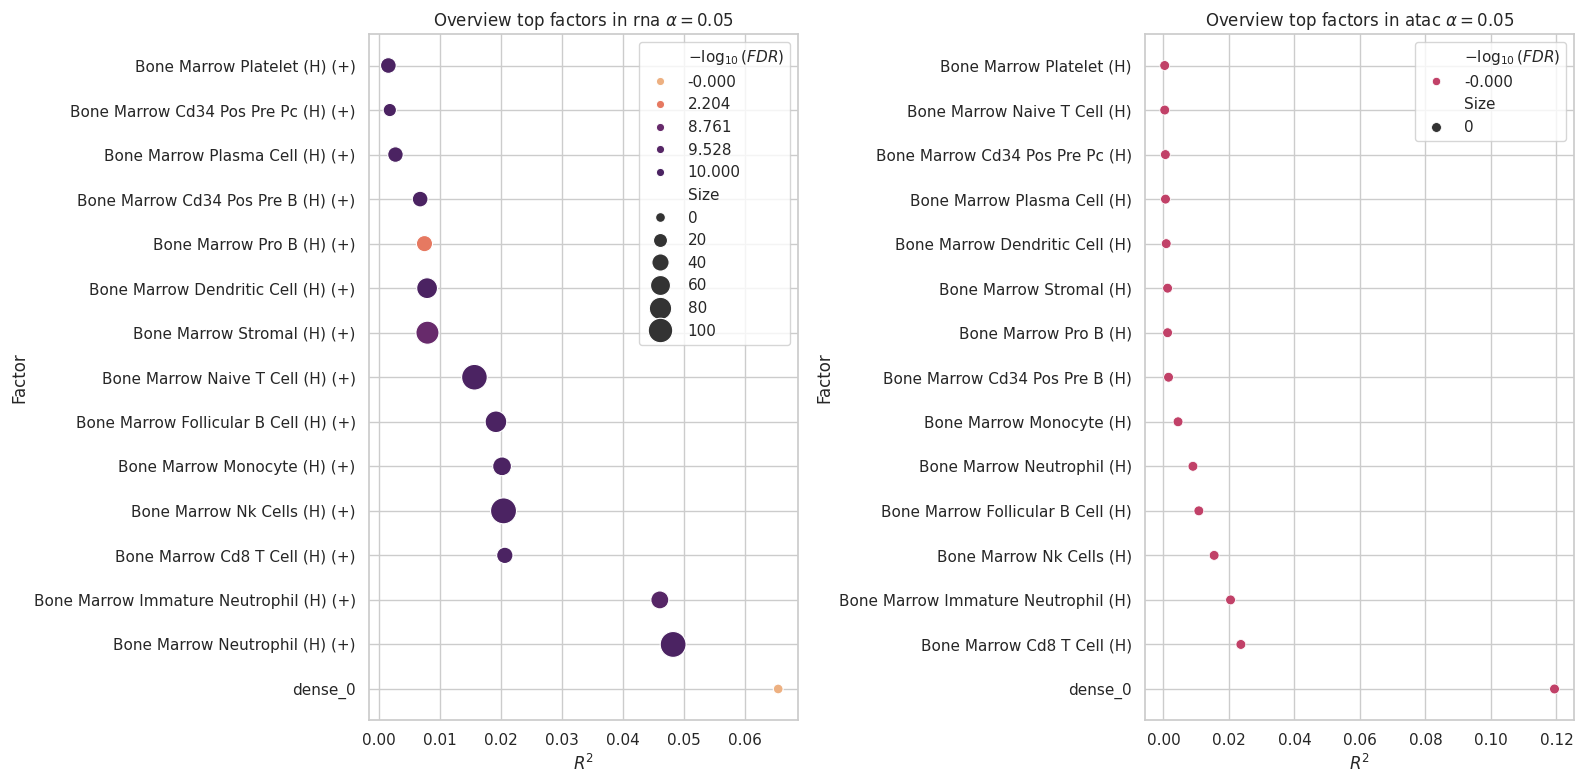

(<Figure size 1600x800 with 2 Axes>,
 array([[<Axes: title={'center': 'Overview top factors in rna $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>,
         <Axes: title={'center': 'Overview top factors in atac $\\alpha = 0.05$'}, xlabel='$R^2$', ylabel='Factor'>]],
       dtype=object))

In [16]:
muvi.pl.factors_overview(model)

In [17]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()
# copy predefined colors
model._cache.factor_adata.uns["rna:celltype_colors"] = mdata["rna"].uns[
    "celltype_colors"
]
model._cache.factor_adata.uns["atac:celltype_colors"] = mdata["atac"].uns[
    "celltype_colors"
]

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [18]:
muvi.tl.filter_factors(model, r2_thresh=0.95)

2024-06-21 15:44:56,345 - muvi.tools.utils - INFO - Filtering down to 10 factors.
2024-06-21 15:44:56,348 - muvi.tools.cache - INFO - Factors filtered successfully.


True

In [19]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:773: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return cluster_fn(setup_cache(model).factor_adata, **kwargs)


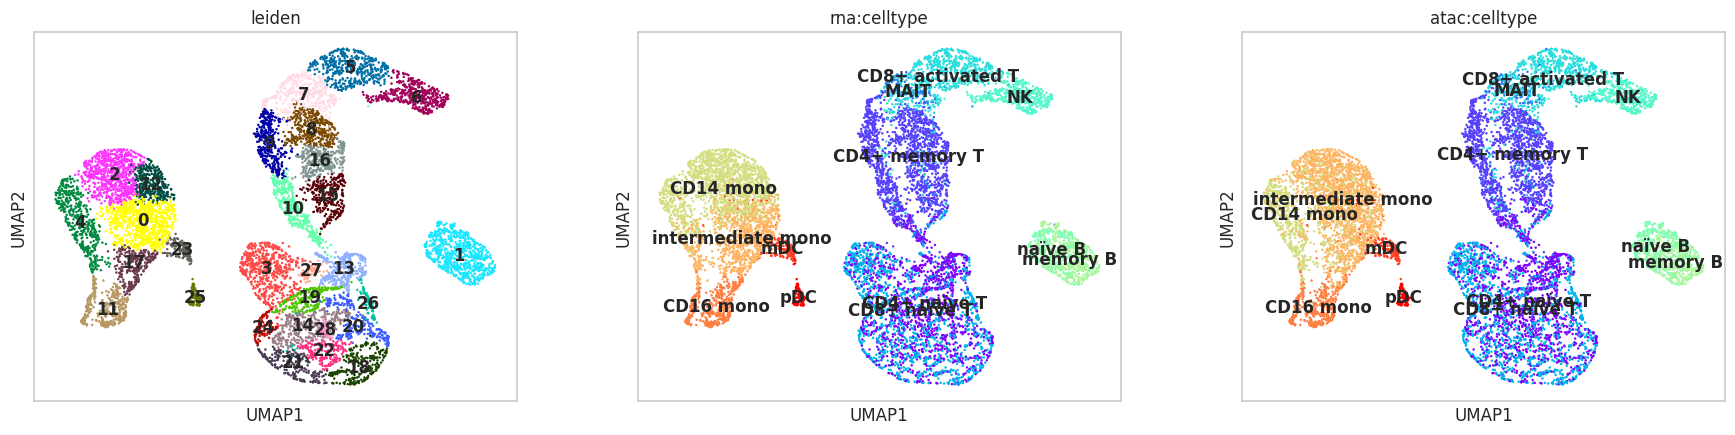

In [20]:
groupby = "leiden"
color = [groupby, "rna:celltype", "atac:celltype"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [21]:
muvi.tl.rank(model, "rna:celltype", method="wilcoxon")

2024-06-21 15:45:56,913 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_rna:celltype` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


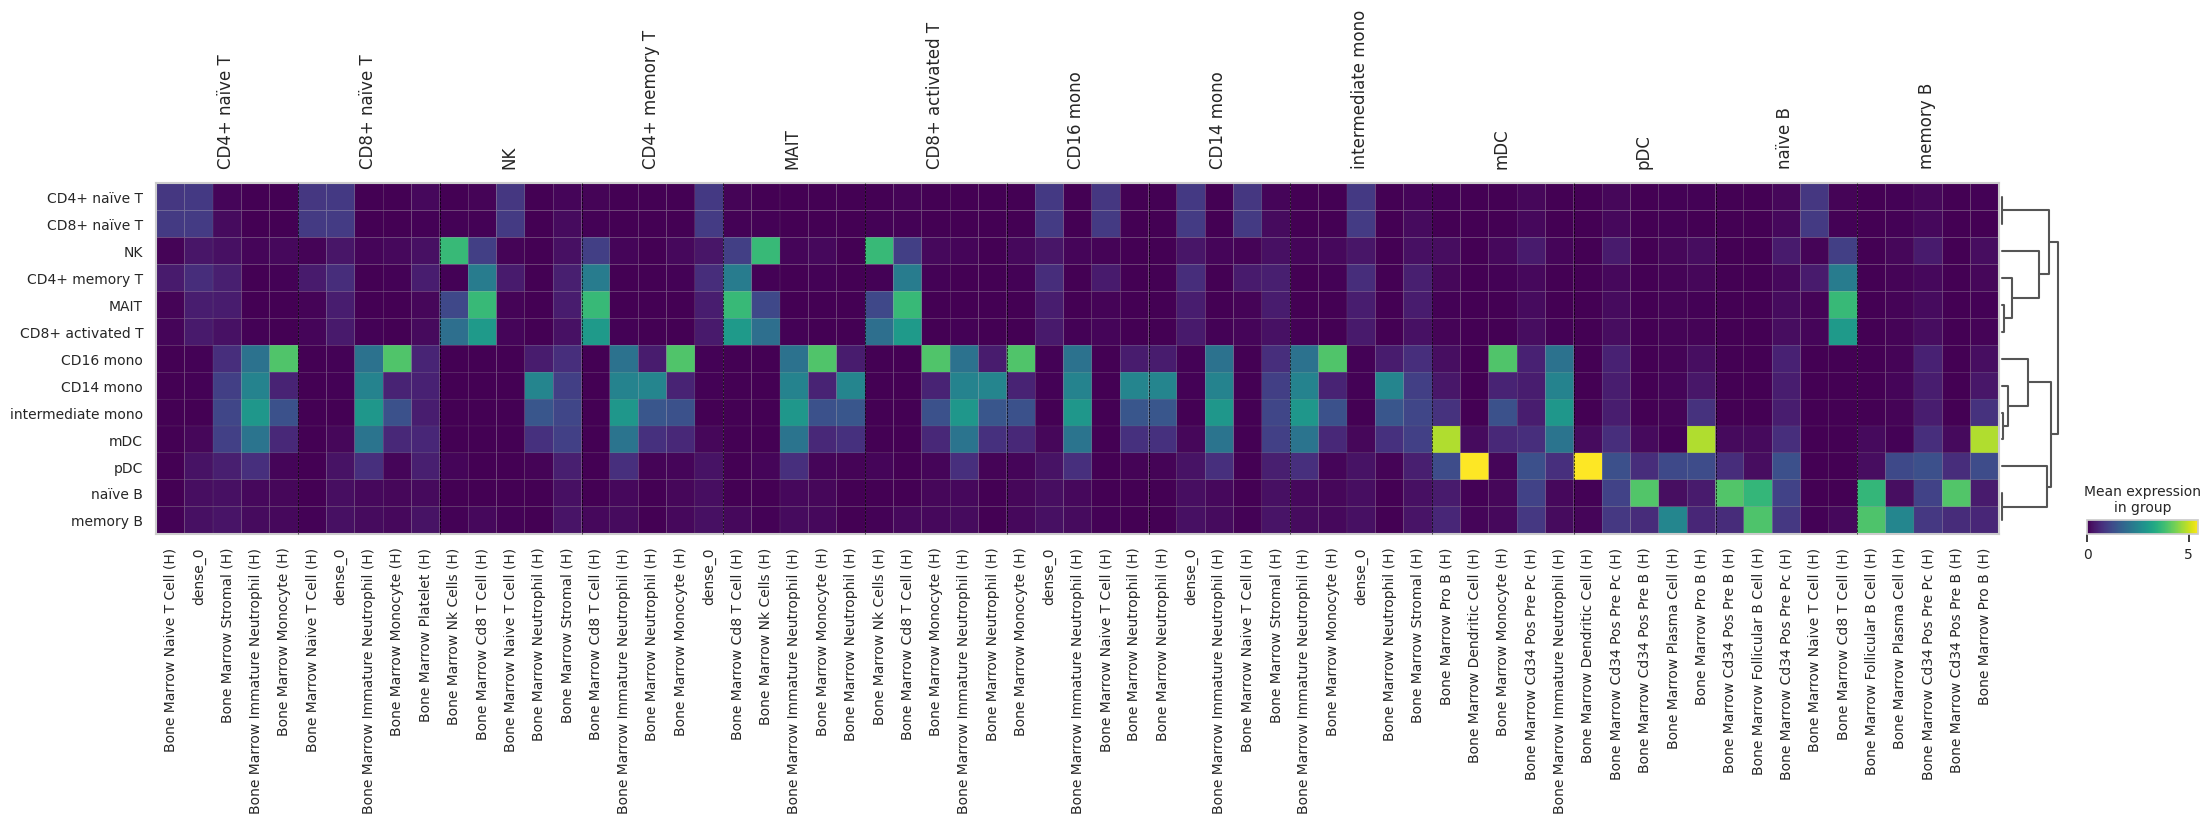

<Axes: >

In [22]:
muvi.pl.rank(model, n_factors=5, pl_type="matrixplot")

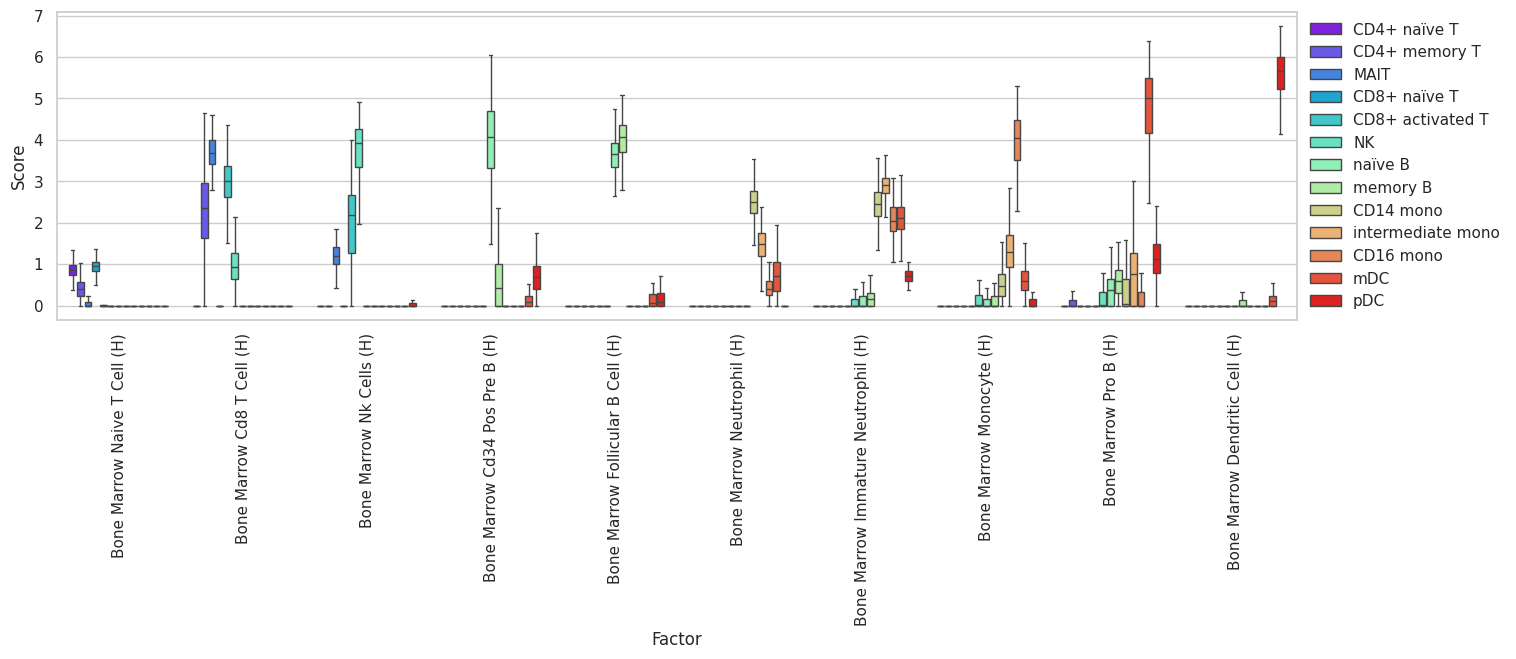

In [23]:
plt.figure(figsize=(16, 4))
relevant_factors, _ = muvi.pl.groupplot_rank(
    model, pl_type="boxplot", rot=90, gap=0.1, showfliers=False
)

In [24]:
groups = [
    "CD14 mono",
    "intermediate mono",
    "CD16 mono",
    "naïve B",
    "memory B",
    "mDC",
    "pDC",
    "NK",
]

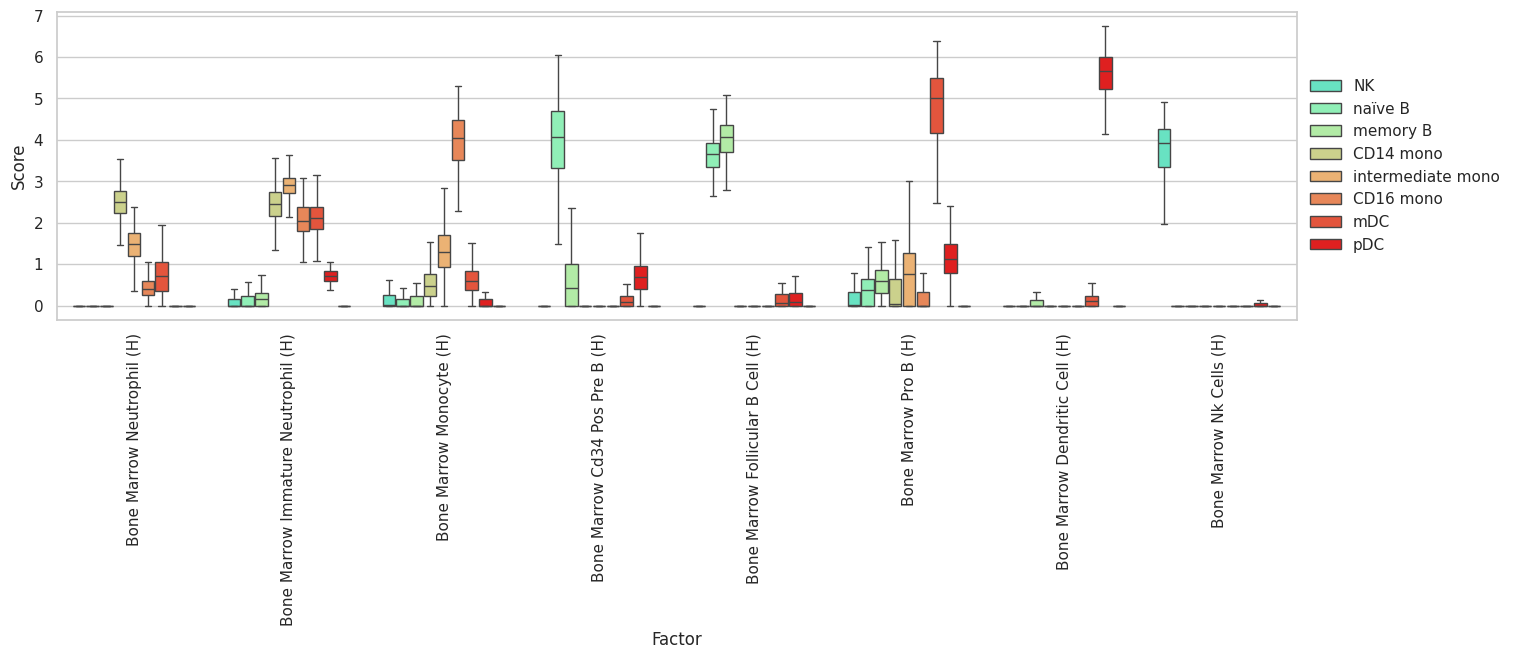

In [25]:
plt.figure(figsize=(16, 4))
relevant_factors, _ = muvi.pl.groupplot_rank(
    model, groups=groups, pl_type="boxplot", rot=90, gap=0.1, showfliers=False
)

We may also compute the group-wise variance explained across all cell types.

In [26]:
_ = muvi.tl.variance_explained_grouped(model, "rna:celltype")

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:412: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metadata.groupby(metadata)


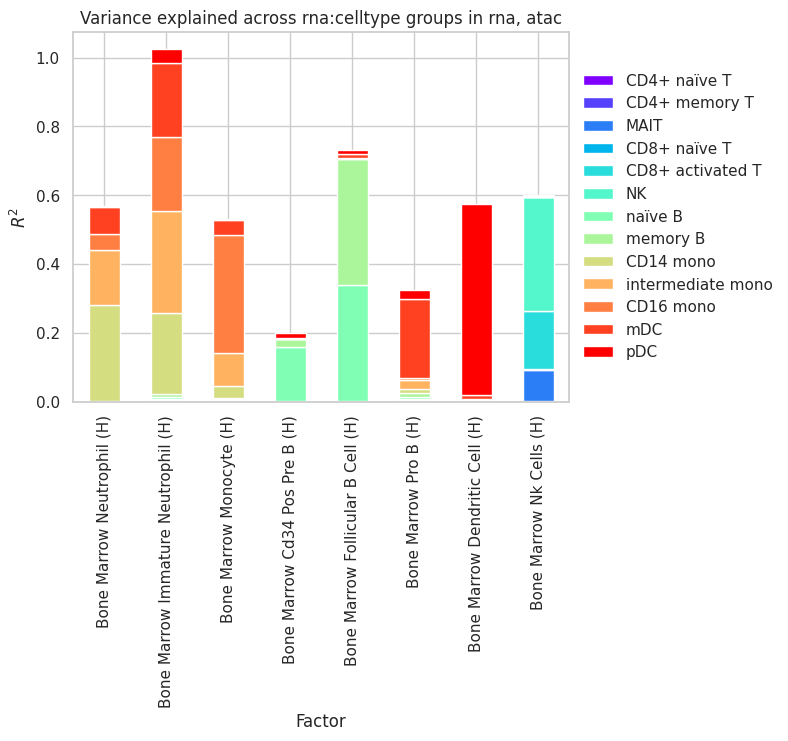

<Axes: title={'center': 'Variance explained across rna:celltype groups in rna, atac'}, xlabel='Factor', ylabel='$R^2$'>

In [27]:
muvi.pl.variance_explained_grouped(model, relevant_factors, stacked=True, rot=90)

We may add a new metadata column for relevant cell types vs the rest and recompute the variance explained across the new groups.

In [28]:
celltypes = muvi.tl.get_metadata(model, "rna:celltype")
celltypes = celltypes.cat.add_categories("other")
celltypes[
    ~celltypes.isin(
        [
            "CD4+ naïve T",
            "CD4+ memory T",
            "MAIT",
            "CD8+ naïve T",
            "CD8+ activated T",
        ]
    )
] = "other"
_ = muvi.tl.add_metadata(model, "T cells vs rest", celltypes)

In [29]:
_ = muvi.tl.variance_explained_grouped(model, "T cells vs rest")

/home/aqoku/projects/code/MuVI/muvi/tools/utils.py:412: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metadata.groupby(metadata)


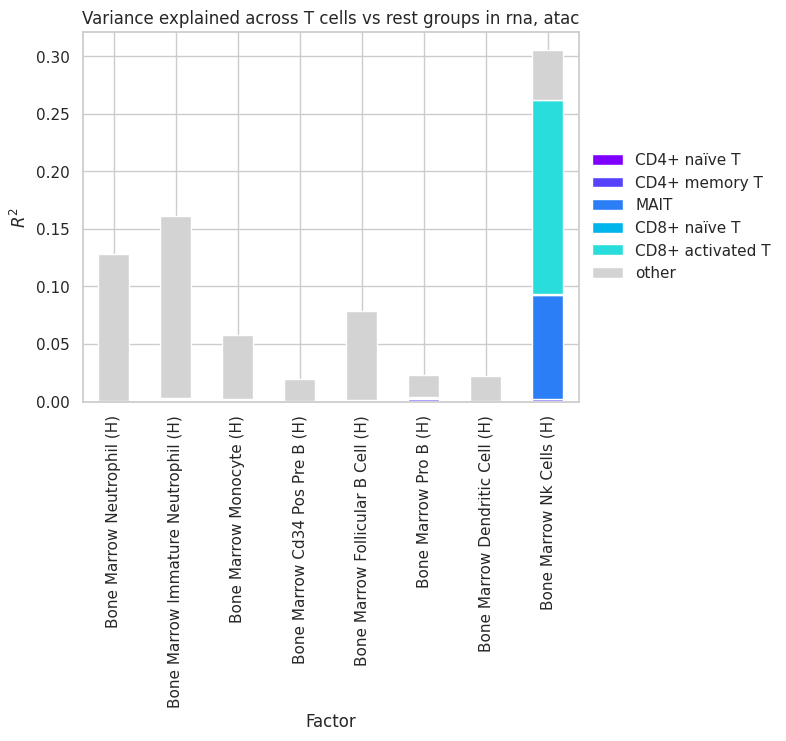

<Axes: title={'center': 'Variance explained across T cells vs rest groups in rna, atac'}, xlabel='Factor', ylabel='$R^2$'>

In [30]:
muvi.pl.variance_explained_grouped(
    model,
    relevant_factors,
    stacked=True,
    color=muvi.pl._get_color_dict(model._cache.factor_adata, "rna:celltype", "other"),
    rot=90,
)

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

Optionally, we can map peaks to gene symbols for better readability. Mapping file [pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv](https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv) downloaded from 10x Genomics.

In [31]:
atac_df = pd.read_csv(
    "pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv", sep="\t", index_col=0
)
atac_df["gene"] = atac_df["gene"].str.split(";").str[0]
s = atac_df.index.str.split("_")
atac_df.index = s.str[0] + ":" + s.str[1] + "-" + s.str[2]
mapping_dict = {k: f"{k[:15]}.. ({v})" for k, v in atac_df["gene"].to_dict().items()}
# mapping_dict
model.feature_names["atac"] = mdata["atac"].var_names.map(mapping_dict)

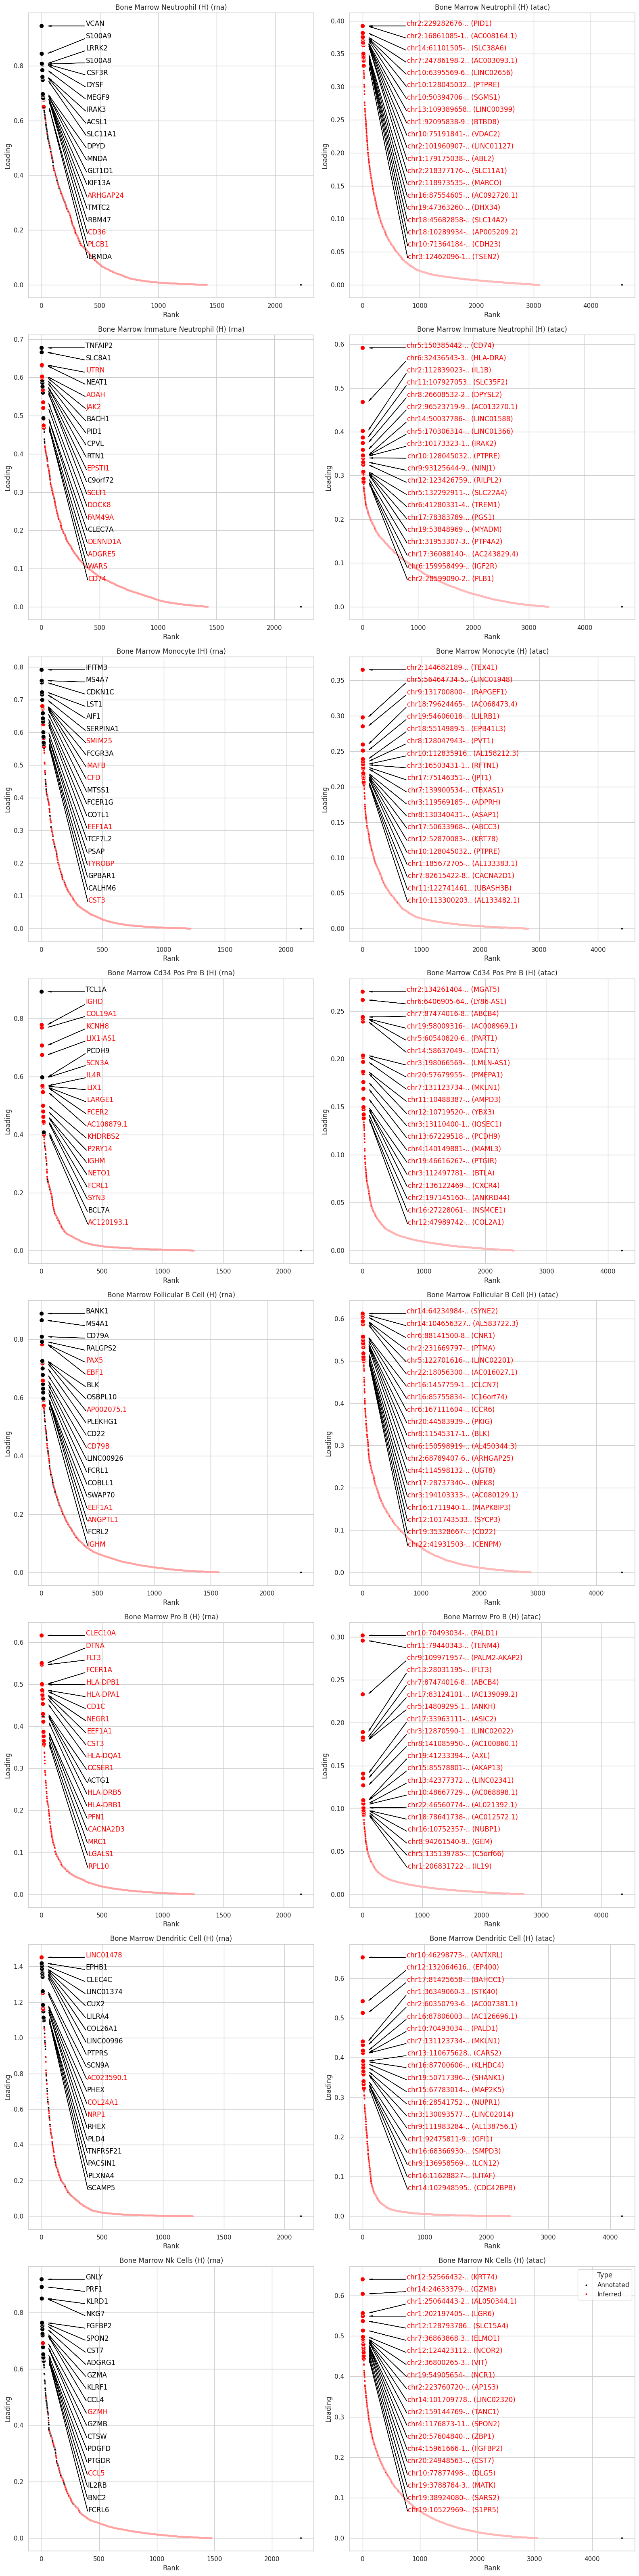

(<Figure size 1600x6400 with 16 Axes>,
 array([[<Axes: title={'center': 'Bone Marrow Neutrophil (H) (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Bone Marrow Neutrophil (H) (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'Bone Marrow Immature Neutrophil (H) (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Bone Marrow Immature Neutrophil (H) (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'Bone Marrow Monocyte (H) (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Bone Marrow Monocyte (H) (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'Bone Marrow Cd34 Pos Pre B (H) (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <Axes: title={'center': 'Bone Marrow Cd34 Pos Pre B (H) (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<Axes: title={'center': 'Bone Marrow Follicular B Cell (H) (rna)'}, xlabel='Rank', ylabel=

In [32]:
muvi.pl.inspect_factor(
    model,
    relevant_factors,
    top=20,
)

Finally, we may `save` the model on disk and `load` it later to resume the analysis.

In [33]:
# muvi.save(model, "some_model_output_directory")
# model = muvi.load("some_model_output_directory")

In addition, we may also save the model as a hierarchical data format (HDF5) in order to load it in R, for instance by the `MOFA2` R package.

In [34]:
muvi.ext.save_as_hdf5(model, "10x_multiome_muvi.hdf5", save_metadata=True)

2024-06-21 15:46:47,389 - muvi.tools.external - WARNING - `10x_multiome_muvi.hdf5` already exists, overwriting.
2024-06-21 15:46:47,391 - muvi.tools.external - INFO - Setting default group name to `group_0` for single group data.
2024-06-21 15:46:47,392 - muvi.tools.external - INFO - Computing variance explained.
2024-06-21 15:46:47,396 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.


Have a look at [this vignette](https://raw.githack.com/MLO-lab/MuVI/master/examples/4_single-cell_multi-omics_integration_R.html) on how to load a `MuVI` model onto `MOFA2` R package for a downstream analysis in R.